## Exploratory Data Analysis

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
import ast
from collections import Counter
from itertools import chain
from wordcloud import WordCloud
from collections import defaultdict
import nltk
from nltk import ngrams
import scipy
from scipy.stats import chi2_contingency
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TextVectorization

### Read Dataset

In [2]:
reddit_df = pd.DataFrame(pd.read_csv('../data/reddit_depression_dataset_cleaned.csv', index_col=0))
reddit_df.head()

,combined_text,tokenized_text,stemmed_text,non_stopword_removed_stemmed_text,upvotes,date,num_comments,label
0,Deep thoughts underdog Only when we start cons...,"['Deep', 'thoughts', 'underdog', 'Only', 'when...","['deep', 'thought', 'underdog', 'start', 'cons...","['deep', 'thought', 'underdog', 'onli', 'when'...",4.0,2014-07-14 03:35:09,0.0,0.0
1,"I like this sub, there's only two posts yet I ...","['I', 'like', 'this', 'sub', ',', 'there', ""'s...","['like', 'sub', 'two', 'post', 'yet', 'keep', ...","['i', 'like', 'thi', 'sub', 'there', 'onli', '...",4.0,2014-09-13 00:31:19,1.0,0.0
2,Rebirth! Hello. \nI am the new guy in charge h...,"['Rebirth', '!', 'Hello', '.', 'I', 'am', 'the...","['rebirth', 'hello', 'new', 'guy', 'charg', 'b...","['rebirth', 'hello', 'i', 'am', 'the', 'new', ...",6.0,2014-11-20 04:31:58,1.0,0.0
3,"""I want to be like water. I want to slip throu...","['``', 'I', 'want', 'to', 'be', 'like', 'water...","['want', 'like', 'water', 'want', 'slip', 'fin...","['i', 'want', 'to', 'be', 'like', 'water', 'i'...",25.0,2014-11-20 19:38:05,2.0,0.0
4,Who am I? You could take any one cell in my bo...,"['Who', 'am', 'I', '?', 'You', 'could', 'take'...","['could', 'take', 'one', 'cell', 'bodi', 'kill...","['who', 'am', 'i', 'you', 'could', 'take', 'an...",5.0,2014-11-20 20:36:52,4.0,0.0


In [3]:
reddit_df.dtypes

combined_text                         object
tokenized_text                        object
stemmed_text                          object
non_stopword_removed_stemmed_text     object
upvotes                              float64
date                                  object
num_comments                         float64
label                                float64
dtype: object

In [4]:
print(type(reddit_df['combined_text'][0]))
print(type(reddit_df['tokenized_text'][0]))
print(type(reddit_df['stemmed_text'][0]))
print(type(reddit_df['non_stopword_removed_stemmed_text'][0]))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


By importing the csv file, the type for `stemmed_text` has become str instead of the indended Array. `combined_text` was already in str. <br>
Hence, we will need to convert `stemmed_text` back.

In [5]:
reddit_df['stemmed_text'] = reddit_df['stemmed_text'].apply(ast.literal_eval)
reddit_df['non_stopword_removed_stemmed_text'] = reddit_df['non_stopword_removed_stemmed_text'].apply(ast.literal_eval)
reddit_df['tokenized_text'] = reddit_df['tokenized_text'].apply(ast.literal_eval)
print(type(reddit_df['stemmed_text'][0]))
print(type(reddit_df['non_stopword_removed_stemmed_text'][0]))
print(type(reddit_df['tokenized_text'][0]))

<class 'list'>
<class 'list'>
<class 'list'>


In [6]:
print(type(reddit_df['upvotes'][0]))
print(type(reddit_df['date'][0]))
print(type(reddit_df['num_comments'][0]))
print(type(reddit_df['label'][0]))

<class 'numpy.float64'>
<class 'str'>
<class 'numpy.float64'>
<class 'numpy.float64'>


Thankfully, `upvotes`, `num_comments` and `label` have kept their float typing. <br>
However, `date` has also been converted into str. So we will be fixing that.

In [7]:
reddit_df['date'] = pd.to_datetime(reddit_df['date'])
type(reddit_df['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [8]:
reddit_df.head()

,combined_text,tokenized_text,stemmed_text,non_stopword_removed_stemmed_text,upvotes,date,num_comments,label
0,Deep thoughts underdog Only when we start cons...,"[Deep, thoughts, underdog, Only, when, we, sta...","[deep, thought, underdog, start, consid, 99, u...","[deep, thought, underdog, onli, when, we, star...",4.0,2014-07-14 03:35:09,0.0,0.0
1,"I like this sub, there's only two posts yet I ...","[I, like, this, sub, ,, there, 's, only, two, ...","[like, sub, two, post, yet, keep, come, back, ...","[i, like, thi, sub, there, onli, two, post, ye...",4.0,2014-09-13 00:31:19,1.0,0.0
2,Rebirth! Hello. \nI am the new guy in charge h...,"[Rebirth, !, Hello, ., I, am, the, new, guy, i...","[rebirth, hello, new, guy, charg, besid, thego...","[rebirth, hello, i, am, the, new, guy, in, cha...",6.0,2014-11-20 04:31:58,1.0,0.0
3,"""I want to be like water. I want to slip throu...","[``, I, want, to, be, like, water, ., I, want,...","[want, like, water, want, slip, finger, hold, ...","[i, want, to, be, like, water, i, want, to, sl...",25.0,2014-11-20 19:38:05,2.0,0.0
4,Who am I? You could take any one cell in my bo...,"[Who, am, I, ?, You, could, take, any, one, ce...","[could, take, one, cell, bodi, kill, would, st...","[who, am, i, you, could, take, ani, one, cell,...",5.0,2014-11-20 20:36:52,4.0,0.0


It also seems that the blanks we had filled in prior have become NaN again, so let's quickly fill those back in.

### Text Analysis

In [9]:
# with tf.device('/GPU:0'):
#     # Convert the non_stopword_removed_stemmed_text column to a RaggedTensor
#     non_stopword_removed_stemmed_text_tensor = tf.ragged.constant(reddit_df['non_stopword_removed_stemmed_text'].tolist())

2024-10-07 11:59:32.973797: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-10-07 11:59:32.973894: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-10-07 11:59:32.973904: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-10-07 11:59:32.973932: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-07 11:59:32.973993: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


0


In [10]:
# non_stopword_removed_stemmed_text_tensor

<tf.RaggedTensor [[b'deep', b'thought', b'underdog', b'onli', b'when', b'we', b'start',
  b'consid', b'ourselv', b'the', b'99', b'to', b'be', b'the', b'underdog',
  b'can', b'we', b'begin', b'to', b'valu', b'ourselv', b'and', b'start',
  b'root', b'for', b'each', b'other']                                     ,
 [b'i', b'like', b'thi', b'sub', b'there', b'onli', b'two', b'post', b'yet',
  b'i', b'keep', b'come', b'back', b'anyway', b'human', b'moral', b'is',
  b'a', b'joke', b'so', b'long', b'as', b'there', b'is', b'abscenc', b'of',
  b'hope', b'deep', b'thought', b'for', b'the', b'day']                     ,
 [b'rebirth', b'hello', b'i', b'am', b'the', b'new', b'guy', b'in',
  b'charg', b'here', b'besid', b'thegood', b'ofc', b'with', b'me', b'i',
  b'bring', b'weirdpineappl', b'you', b'may', b'know', b'him', b'from',
  b'http', b'we', b'will', b'be', b'do', b'our', b'best', b'to', b'keep',
  b'thi', b'subreddit', b'aliv', b'have', b'fun']                        ,
 ...,
 [b'i', b'know',

In [ ]:
# with tf.device('/GPU:0'):
#     bigrams = tf.strings.ngrams(non_stopword_removed_stemmed_text_tensor, 2, separator='')
# print(bigrams.to_list())

In [ ]:
# trigrams = tf.strings.ngrams(non_stopword_removed_stemmed_text_array, 3, separator=' ')

In [ ]:
print(bigrams.numpy())
print("\nTrigrams:")
print(trigrams.numpy())

Here, we are trying to find the 20 most common words that appear in posts.

In [9]:
# Flatten the list of stemmed words and count the occurrences
word_counts = Counter(chain.from_iterable(reddit_df['stemmed_text']))

# Get the most common words
most_common_words = word_counts.most_common(20)

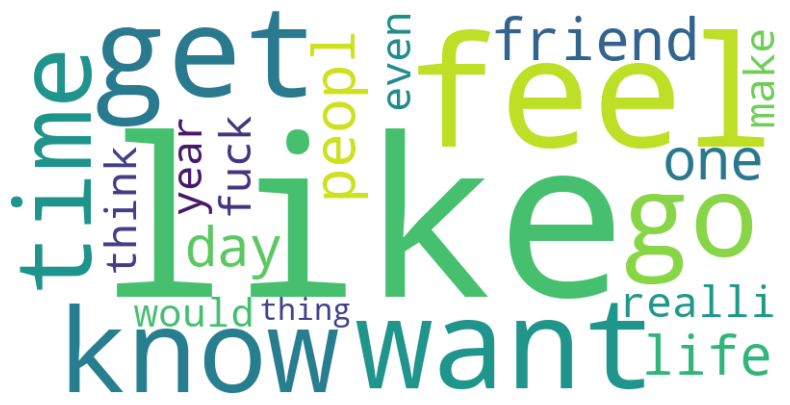

In [10]:
# Convert the most_common_words list to a dictionary
word_freq = dict(most_common_words)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Placing it into a wordcloud puts into perspective the types of words used. The most prominent one being "like".

In [11]:
# Create a DataFrame from the word frequency dictionary
word_freq_df = pd.DataFrame(list(word_freq.items()), columns=['Words', 'Frequency'])

# Create a horizontal bar chart
fig = px.bar(word_freq_df, x='Frequency', y='Words', orientation='h', title='Top 20 Most Common Words')

# Update the layout to display the highest frequency at the top
fig.update_layout(yaxis=dict(autorange="reversed"))

# Show the plot
fig.show()

An interactive bar graph version of the word cloud.

In [ ]:
# Join the array of strings in each row into a single string
reddit_df['joined_text'] = reddit_df['non_stopword_removed_stemmed_text'].apply(' '.join)
    
# Create a dataset from the text column
ngram_df = tf.data.Dataset.from_tensor_slices(df['joined_text'].values)
    
# Create a TextVectorization layer for bigrams
vectorize_layer = TextVectorization(
    ngrams=(2, 2),  # Only bigrams
    output_mode='count'
)
    
# Adapt the layer to the data
vectorize_layer.adapt(ngram_df.batch(64))
    
# Get the vocabulary of bigrams
vocab = vectorize_layer.get_vocabulary()
    
# Apply the vectorization to get bigram counts
bigram_counts = vectorize_layer(ngram_df.batch(64))
    
# Sum counts across all documents
total_counts = tf.reduce_sum(bigram_counts, axis=0)
    
# Get the indices of the top N bigrams
top_indices = tf.argsort(total_counts, direction='DESCENDING')[:top_n]
    
# Get the top N bigrams and their counts
top_bigrams = [(vocab[i], int(total_counts[i])) for i in top_indices.numpy()]

Next, we try to find the words most associated with each label: Depression and Non-Depression.

In [43]:
# Function to get the most common words for a given label
def get_most_common_words(df, label, top_n=20):
    word_counts = Counter(chain.from_iterable(df[df['label'] == label]['stemmed_text']))
    return word_counts.most_common(top_n)

# Get the most common words for each label
most_common_words_depressed = get_most_common_words(reddit_df, 1.0)
most_common_words_not_depressed = get_most_common_words(reddit_df, 0.0)

print("Most common words for depressed label:")
print(most_common_words_depressed)

print("\nMost common words for not depressed label:")
print(most_common_words_not_depressed)

Most common words for depressed label:
[('feel', 722900), ('like', 619492), ('want', 569986), ('get', 480092), ('know', 445176), ('life', 430416), ('go', 425501), ('time', 360604), ('even', 323400), ('peopl', 321138), ('depress', 308526), ('year', 299914), ('friend', 289287), ('think', 288097), ('one', 286592), ('would', 284303), ('thing', 281262), ('realli', 274701), ('tri', 265724), ('day', 265037)]

Most common words for not depressed label:
[('like', 764508), ('get', 487421), ('go', 383856), ('know', 382486), ('want', 381123), ('friend', 360704), ('one', 331600), ('peopl', 323895), ('fuck', 323810), ('day', 313822), ('feel', 310920), ('time', 302501), ('realli', 281656), ('school', 281185), ('make', 270808), ('think', 265421), ('say', 254332), ('guy', 253331), ('got', 252014), ('girl', 247493)]


Here we can already see that there are some differences in the ranking between depressed and non-depressed.

Placing them into their own individual word clouds:

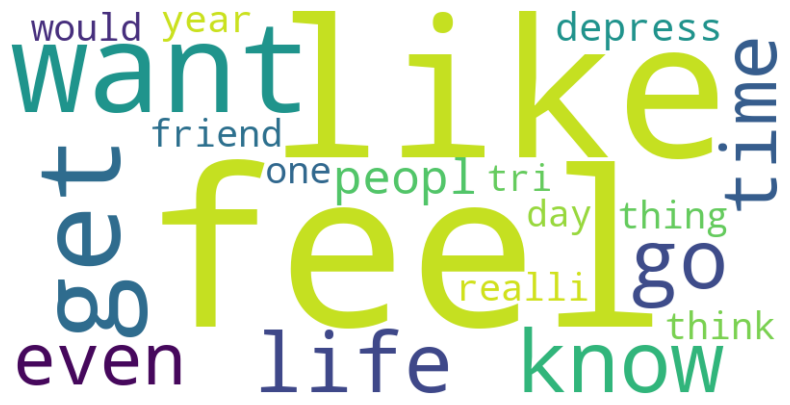

In [44]:
# Convert the most_common_words list to a dictionary
word_freq = dict(most_common_words_depressed)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

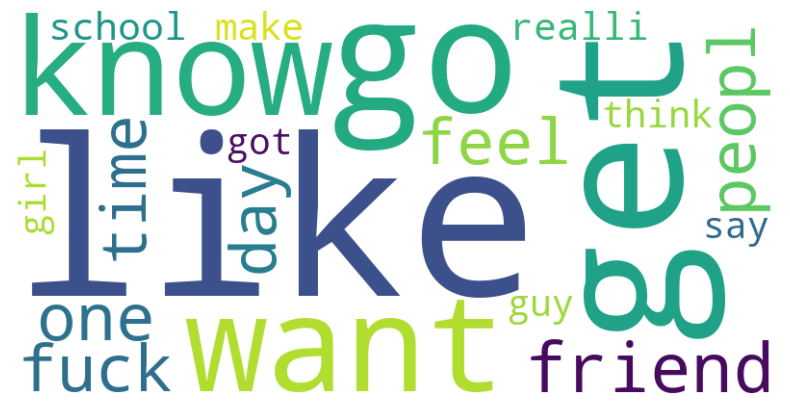

In [45]:
# Convert the most_common_words list to a dictionary
word_freq = dict(most_common_words_not_depressed)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Although the most commonly used words give good insight, it is nothing without the context it came from, especially if we are trying to determine the presence and magnitude of mental health such as depression.

Thus, we look towards n-grams to identify the adjacent words, bringing in some context when filtering for the most common words/phrases.

In [25]:
# nltk.data.path.append("nltk_data")
# nltk.download('punkt', download_dir='nltk_data', quiet=True)
# nltk.download('punkt_tab', download_dir='nltk_data', quiet=True)

# def analyze_ngrams(df, text_column, n=2, top_n=20):
#     # Function to generate n-grams
#     def generate_ngrams(text, n):
#         return list(ngrams(text, n))

#     # Apply the function to the text column and flatten the list of lists
#     all_ngrams = list(chain.from_iterable(df[text_column].apply(lambda x: generate_ngrams(x, n))))

#     # Count the occurrences of each n-gram
#     ngram_counts = Counter(all_ngrams)

#     # Get the most common n-grams
#     most_common_ngrams = ngram_counts.most_common(top_n)

#     return most_common_ngrams

# most_common_bigrams = analyze_ngrams(reddit_df, 'stemmed_text', n=3, top_n=20)

# print("Most common bigrams:")
# for ngram, count in most_common_bigrams:
#     print(f"{ngram}: {count}")

Most common bigrams:
('filler', 'filler', 'filler'): 94023
('gt', 'pop', 'lt'): 55169
('pop', 'lt', 'gt'): 55067
('lt', 'gt', 'pop'): 55057
('fuck', 'fuck', 'fuck'): 49661
('bruh', 'bruh', 'bruh'): 23481
('never', 'gon', 'na'): 19898
('amp', 'amp', 'amp'): 18149
('sex', 'sex', 'sex'): 16670
('cum', 'cum', 'cum'): 15456
('bean', 'bean', 'bean'): 14572
('chees', 'chees', 'chees'): 13696
('amp', 'x200b', 'amp'): 12297
('x200b', 'amp', 'x200b'): 12295
('feel', 'like', 'shit'): 11416
('play', 'video', 'game'): 10613
('http', 'amp', 'amp'): 10464
('oui', 'oui', 'oui'): 10015
('69', '69', '69'): 10002
('make', 'feel', 'like'): 9627


But the results here are not helpful.

Apart from text frequency, we can also try to idetify a correlation between the length of the text, and other attributes such as `upvotes`, `date`, `num_comments` and `label`.

First, we determine the number of words in each post.

In [12]:
reddit_df['word_count'] = reddit_df['tokenized_text'].apply(len)
reddit_df.head()

,combined_text,tokenized_text,stemmed_text,upvotes,date,num_comments,label,word_count
0,Deep thoughts underdog Only when we start cons...,"[Deep, thoughts, underdog, Only, when, we, sta...","[deep, thought, underdog, start, consid, 99, u...",4.0,2014-07-14 03:35:09,0.0,0.0,31
1,"I like this sub, there's only two posts yet I ...","[I, like, this, sub, ,, there, 's, only, two, ...","[like, sub, two, post, yet, keep, come, back, ...",4.0,2014-09-13 00:31:19,1.0,0.0,38
2,Rebirth! Hello. \nI am the new guy in charge h...,"[Rebirth, !, Hello, ., I, am, the, new, guy, i...","[rebirth, hello, new, guy, charg, besid, thego...",6.0,2014-11-20 04:31:58,1.0,0.0,53
3,"""I want to be like water. I want to slip throu...","[``, I, want, to, be, like, water, ., I, want,...","[want, like, water, want, slip, finger, hold, ...",25.0,2014-11-20 19:38:05,2.0,0.0,25
4,Who am I? You could take any one cell in my bo...,"[Who, am, I, ?, You, could, take, any, one, ce...","[could, take, one, cell, bodi, kill, would, st...",5.0,2014-11-20 20:36:52,4.0,0.0,472


Then we transform the values to place on the same scale for better comparisons between one another.

In [13]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to the specified columns
reddit_df[['scaled_upvotes', 'scaled_num_comments', 'scaled_word_count']] = scaler.fit_transform(reddit_df[['upvotes', 'num_comments', 'word_count']])

# Display the first few rows to verify the transformation
reddit_df.head()

,combined_text,tokenized_text,stemmed_text,upvotes,date,num_comments,label,word_count,scaled_upvotes,scaled_num_comments,scaled_word_count
0,Deep thoughts underdog Only when we start cons...,"[Deep, thoughts, underdog, Only, when, we, sta...","[deep, thought, underdog, start, consid, 99, u...",4.0,2014-07-14 03:35:09,0.0,0.0,31,0.000000,0.000142,0.000636
1,"I like this sub, there's only two posts yet I ...","[I, like, this, sub, ,, there, 's, only, two, ...","[like, sub, two, post, yet, keep, come, back, ...",4.0,2014-09-13 00:31:19,1.0,0.0,38,0.000000,0.000189,0.000780
2,Rebirth! Hello. \nI am the new guy in charge h...,"[Rebirth, !, Hello, ., I, am, the, new, guy, i...","[rebirth, hello, new, guy, charg, besid, thego...",6.0,2014-11-20 04:31:58,1.0,0.0,53,0.000016,0.000189,0.001088
3,"""I want to be like water. I want to slip throu...","[``, I, want, to, be, like, water, ., I, want,...","[want, like, water, want, slip, finger, hold, ...",25.0,2014-11-20 19:38:05,2.0,0.0,25,0.000163,0.000237,0.000513
4,Who am I? You could take any one cell in my bo...,"[Who, am, I, ?, You, could, take, any, one, ce...","[could, take, one, cell, bodi, kill, would, st...",5.0,2014-11-20 20:36:52,4.0,0.0,472,0.000008,0.000331,0.009685


Now, we create the correlation matrix between the attributes and plot a heatmap to visualize their relationships.

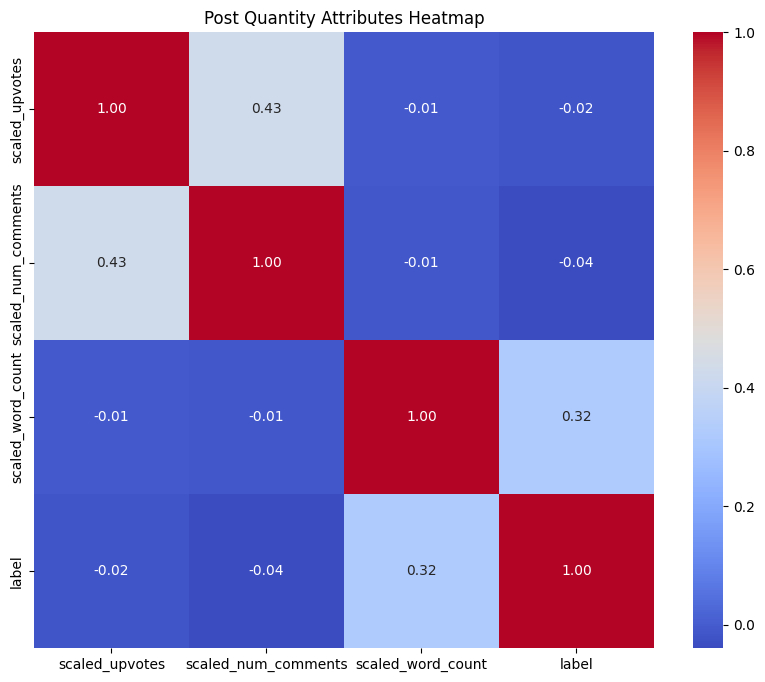

In [14]:
# Compute the correlation matrix
correlation_matrix = reddit_df[['scaled_upvotes', 'scaled_num_comments', 'scaled_word_count', 'label']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Post Quantity Attributes Heatmap')
plt.show()

Based on the correlation matrix visualized by the heatmap, we can infer that there are weak negative correlations from the following: 
- Between the number of upvotes and comments a post gets.
- Between the the amount of words a post has and if the post is from a depressed individual or not.

Although this is new knowledge, the correlation is not strong.

### Temporal Analysis

Earlier we focued on the text of posts. Now, we will look more into the posts' performance over time.

To start, let's find the range of dates available.

In [15]:
min_date = reddit_df['date'].min()
max_date = reddit_df['date'].max()

print(f"Minimum Date: {min_date}")
print(f"Maximum Date: {max_date}")

Minimum Date: 2008-01-26 02:17:12
Maximum Date: 2022-12-31 23:58:35


Then, we plot a line time-series graph to show the progression of post frequency over time. <br>
We will use quarterly intervals (3 months) to compact the data.

In [53]:
# Group by month and count the number of posts per month
quarterly_counts = reddit_df['date'].dt.to_period('Q').value_counts().sort_index()

# Plot the time series graph using Plotly
fig = px.line(x=quarterly_counts.index.astype(str), y=quarterly_counts.values, markers=True, title='Frequency of Posts Over Time (Quarterly)')
fig.update_layout(xaxis_title='Quarter', yaxis_title='Number of Posts')
fig.show()


From the graph, we see that the number of posts are relatively low from 2008 up to 2018, to which it has a small fluctuation. <br>
Following that, nearing the end of 2018, there is a massive spike in depression post frequency, which then gradually decreased over the next 3 years, nearly reaching back its globabl minima.

In [17]:
# Filter the DataFrame for dates from 2018 Q2 onwards
date_filtered_reddit_df = reddit_df[reddit_df['date'] >= '2018-04-01']
monthly_counts = date_filtered_reddit_df['date'].dt.to_period('M').value_counts().sort_index()


# Create a bar chart for monthly post frequencies
fig = px.bar(x=monthly_counts.index.astype(str), y=monthly_counts.values, title='Monthly Post Frequencies')
fig.update_layout(xaxis_title='Month', yaxis_title='Number of Posts')
fig.show()

Zooming into 2018 onwards, we have a more detailed look at the frequency of each month, with July 2019 being the month with the high number of posts related to depression.

### Engagement Analysis

Let's start looking into the continious variables. <br>
We will start by plotting scatter plots for `scaled_upvotes`, `scaled_num_comments`, `scaled_word_count` and `label`.

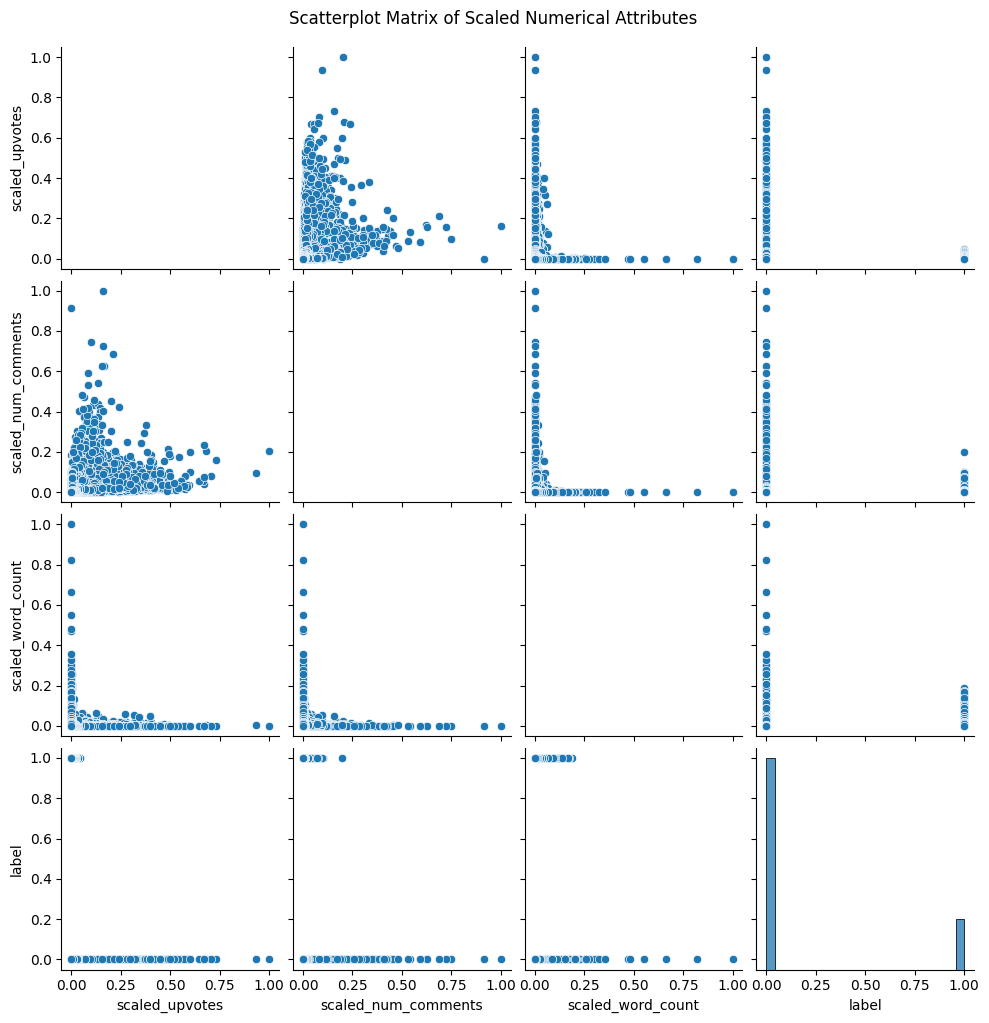

In [19]:
# Create a scatterplot matrix of all scaled numerical attributes against themselves
sns.pairplot(reddit_df[['scaled_upvotes', 'scaled_num_comments', 'scaled_word_count', 'label']])
plt.suptitle('Scatterplot Matrix of Scaled Numerical Attributes', y=1.02)
plt.show()

As expected, we do not see any linear between any of the variables, as proven by the correlation matrix. <br>
However, the comparison with the most variance is `scaled_upvotes` and `scaled_num_comments`. So we that take a closer look at that.

Here, we re-plot the scatter plot between the two. <br>
We also include `scaled_word_count` as the hue to show the 3rd dimension via magnititude/intensity of each dot.

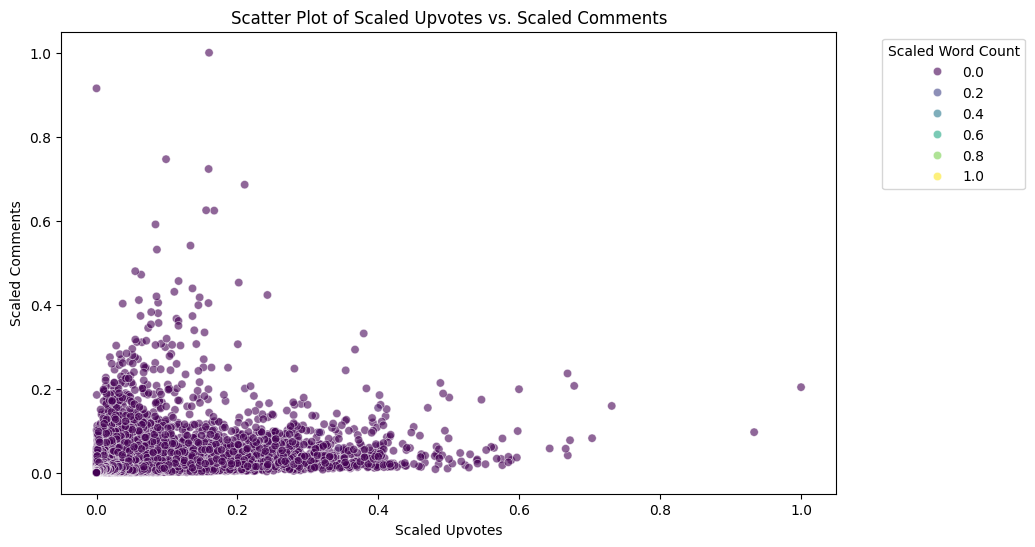

In [18]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=reddit_df, x='scaled_upvotes', y='scaled_num_comments', hue='scaled_word_count', palette='viridis', alpha=0.6)

# Add titles and labels
plt.title('Scatter Plot of Scaled Upvotes vs. Scaled Comments')
plt.xlabel('Scaled Upvotes')
plt.ylabel('Scaled Comments')
plt.legend(title='Scaled Word Count', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Some key observations:
- Distribution: There's a high concentration of data points in the lower left corner, indicating that most posts have relatively low numbers of both upvotes and comments.
- Negative correlation: As scaled upvotes increase, there's a general trend of decreasing scaled comments. This suggests that posts with more upvotes tend to have fewer comments relative to their popularity.
- Outliers: There are some notable outliers, particularly along the y-axis, representing posts with a high number of comments relative to their upvotes.
- Word count: The legend suggests that the color of the points represents the scaled word count, ranging from 0.0 to 1.0. However, almost all visible points are purple, corresponding to a scaled word count of 0.0. This could mean that most posts have relatively short word counts, or the scaling method has compressed the majority of word counts to the lower end of the scale.
- Range: Both axes are scaled from 0 to 1, indicating these are normalized values rather than raw counts.
- Sparse upper right: There are very few points in the upper right quadrant, suggesting it's rare for posts to have both high upvotes and high comment counts relative to the dataset.

This concludes that there is no real relationship between he popularity/quality of a post, and the amount of engagement it gets.

### Label Distribution

Let's look at `label` our target variable in this dataset. <br>
We know that it indicates if the post is from someone with/without depression based on it's binary classification.
- 0 = Not Depresed
- 1 = Depressed

Let's start with a simple proportion comparison.

In [20]:
# Count the occurrences of each label
label_counts = reddit_df['label'].value_counts()

# Create a pie chart
fig = px.pie(values=label_counts.values, names=label_counts.index, title='Distribution of Labels')
fig.show()

Here we can see that the proportion is generally 20% depressed and 80% not. <br>
We could tie it to the 20-80 Rule where 80% of outcomes comes from 20% of causes. <br>
In this case, 20% of the depressed posts leads to 80% of the non-depressed posts as a countermeasure.

Let's now look into this proportion over time.

In [21]:
# Extract the year from the date column
reddit_df['year'] = reddit_df['date'].dt.year

# Group by year and label, then count the occurrences
label_yearly_counts = reddit_df.groupby(['year', 'label']).size().unstack(fill_value=0)

# Create a bar chart to visualize the yearly distribution of labels
fig = px.bar(label_yearly_counts, barmode='group', title='Yearly Distribution of Labels')
fig.update_layout(xaxis_title='Year', yaxis_title='Count', legend_title='Label')
fig.show()

Interestingly, the number of depression posts have been slowly and stadily increasing over time. <br>
But more shockingly, the massive increase in non-depression posts post-2018 is astounding. <br>
This implies that there must have been event(s) during that time period that have brought awareness to this mental health issue.

Next, we perform a Chi-Square test. <br>
This will give us some insight into if there are any statistical relationships between the text and the labels.

In [47]:
# Create a contingency table
word_label_counts = defaultdict(lambda: [0, 0])

for index, row in reddit_df.iterrows():
    for word in row['stemmed_text']:
        word_label_counts[word][int(row['label'])] += 1

# Convert the dictionary to a DataFrame
contingency_table = pd.DataFrame.from_dict(word_label_counts, orient='index', columns=['Not Depressed', 'Depressed'])

# Perform the Chi-Square test
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")

Chi-Square Statistic: 11824260.603897577
P-value: 0.0
Degrees of Freedom: 338823


From the results here, it shows overwhelming positivity/significance that the text in each post are relevant to the label/topic they are associated with. <br>
Although this does not imply causation, where the contents of the post directly equals to the type of post, a p-value of 0 is a very extreme result.

Lastly, we want to look at the distribution in `upvotes` based on the `label` associated with the post.

In [51]:
# Group by month and label, then sum the upvotes
monthly_upvotes = reddit_df.groupby([reddit_df['date'].dt.to_period('Y'), 'label'])['upvotes'].sum().unstack(fill_value=0)

# Convert Period index to string
monthly_upvotes.index = monthly_upvotes.index.astype(str)

# Create a bar chart to visualize the monthly upvotes per label
fig = px.bar(monthly_upvotes, barmode='group', title='Yearly Upvotes per Label')
fig.update_layout(xaxis_title='Month', yaxis_title='Total Upvotes', legend_title='Label')
fig.show()

The trend here is similar to the previous time-based graphs. <br>
However, what was not to expectations was the proportion of upvotes per label. <br>
One may assume that a depression post would get more upvotes than a non-depression one to bring more awareness about the situation. <br>
However, this scale can be due to the disproportion in depression/non-depression posts.

With this insight, we would also want to compare the `num_comments` agains the label over time too.

In [52]:
# Group by month and label, then sum the upvotes
monthly_upvotes = reddit_df.groupby([reddit_df['date'].dt.to_period('Y'), 'label'])['num_comments'].sum().unstack(fill_value=0)

# Convert Period index to string
monthly_upvotes.index = monthly_upvotes.index.astype(str)

# Create a bar chart to visualize the monthly upvotes per label
fig = px.bar(monthly_upvotes, barmode='group', title='Yearly Comments per Label')
fig.update_layout(xaxis_title='Month', yaxis_title='Total Comments', legend_title='Label')
fig.show()

Here, the number of comments draws a slightly different graph. <br>
Unlike the frequencies and upvotes time series, the number of comments on these posts do not diminish post 2019.
This, could imply a retained awareness and interest in such mental health issues after its sudden relevance in 2018.